# Finding fault scarps

This uses the Scarp template to detect scarp-like landforms and estimate their height and relative age.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.warnings.filterwarnings('ignore')

In [2]:
import scarplet as sl
from scarplet.WindowedTemplate import Scarp

The test data comes from the Carrizo Plain section of the San Andreas Fault. It covers part of the Wallace Creek site, a set of offset channels and related scarps and gulleys that have been studied in detail by earthquake geologists and geophysicists. This high resolution  lidar dataset (0.5 m) was downloaded from [OpenTopography](http://opentopography.org), a data facility for high-resolution topographic data.

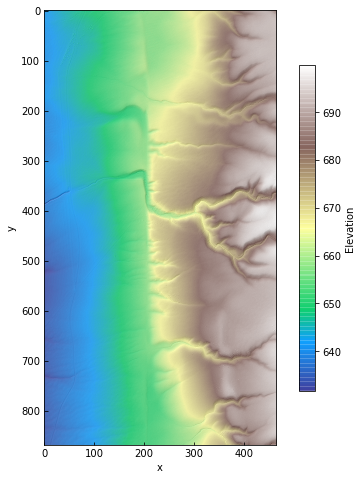

In [3]:
data = sl.load('data/faultzone.tif')
dx = data._georef_info.dx
data.plot(color=True, figsize=(8,8))

In [4]:
# Look for scarps of a single morphologic age
params = {'scale': 100,
          'age': 100.,
          'ang_min': -10 * np.pi / 2,
          'ang_max': 10 * np.pi / 2
         }

res = sl.match(data, Scarp, **params)

In [5]:
amp, age, angle, snr = res

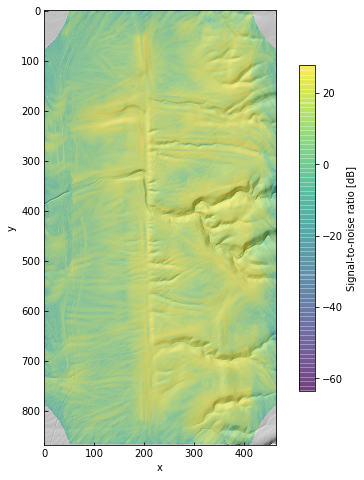

In [6]:
data.plot(color=False, figsize=(8, 8))
ax = plt.gca()
im = ax.imshow(10 * np.log10(snr), alpha=0.5, cmap='viridis')
cb = plt.colorbar(im, ax=ax, shrink=0.75, label='Signal-to-noise ratio [dB]')

In fact, the sign of the template amplitude is determined by the aspect of the scarp. We will mask by SNR and discard the sign of the amplitude -- we just want to see how tall the scarps might be.

In [7]:
mask = snr < 100
amp[mask] = np.nan
amp = np.abs(amp)

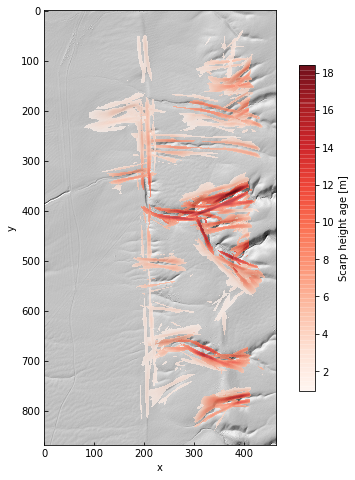

In [8]:
data.plot(color=False, figsize=(8, 8))
ax = plt.gca()
im = ax.imshow(amp, alpha=0.75, cmap='Reds')
cb = plt.colorbar(im, ax=ax, shrink=0.75, label='Scarp height age [m]')

From the amplitude field, we can see that there are some false positives -- the channels on the right of the image -- as well as amplitude gradients along the main fault trace.

That was for just one relative age, 10 m$^2$. If we don't provide an `age` parameter it will search over a large range of ages from 0 to 3000 m$^2$.

In [9]:
# Search over all ages in default range
# This can be slow on a laptop!
res = sl.match(data, Scarp, scale=100.)

Again, we'll do some masking to discard false positives and low-SNR features

In [10]:
angle, snr = [res[2], res[3]]
mask = snr < 100

# Mask out low SNR pixels
res = np.array(res)
res[:, mask] = np.nan

# Mask out pixels with orientations far from vertical
ew = np.abs(angle) >= 5 * np.pi / 180.
res[:, ew] = np.nan

# Mask out pixels on edges of dataset (for roads)
res[:, :, 0:150] = np.nan
res[:, :, -150:] = np.nan

amp, age, angle, snr = res
amp = np.abs(amp)

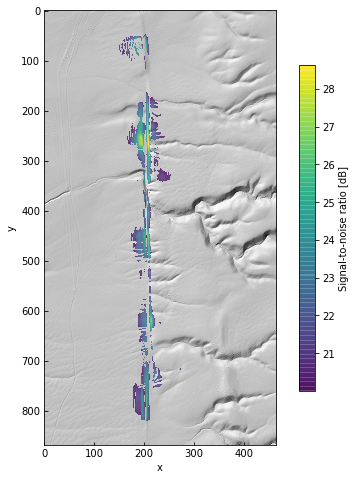

In [11]:
data.plot(color=False, figsize=(8, 8))
ax = plt.gca()
im = ax.imshow(10 * np.log10(res[3]), alpha=0.75, cmap='viridis')
cb = plt.colorbar(im, ax=ax, shrink=0.75, label='Signal-to-noise ratio [dB]')

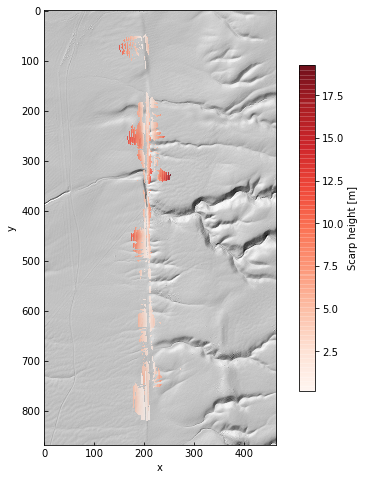

In [12]:
data.plot(color=False, figsize=(8, 8))
ax = plt.gca()
im = ax.imshow(amp, alpha=0.75, cmap='Reds')
cb = plt.colorbar(im, ax=ax, shrink=0.75, label='Scarp height [m]')

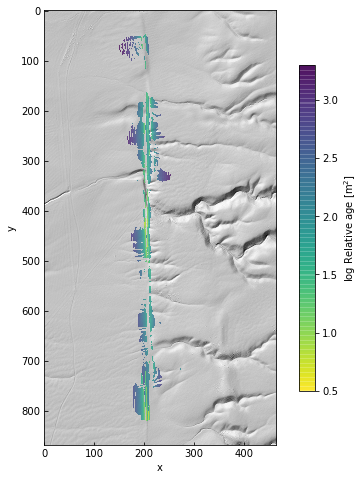

In [13]:
data.plot(color=False, figsize=(8, 8))
ax = plt.gca()
im = ax.imshow(np.log10(age), alpha=0.75, cmap='viridis_r')
cb = plt.colorbar(im, ax=ax, shrink=0.75, label='log Relative age [m$^2$]')

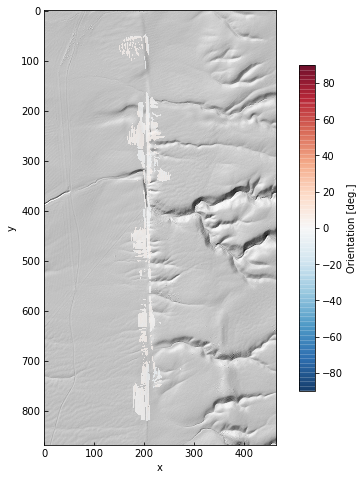

In [14]:
data.plot(color=False, figsize=(8, 8))
ax = plt.gca()
im = ax.imshow(angle * 180 / np.pi, alpha=0.75, cmap='RdBu_r', vmin=-90, vmax=90)
cb = plt.colorbar(im, ax=ax, shrink=0.75, label='Orientation [deg.]')

The parameter grids are just Numpy arrays. This gives us the option of looking at along-strike variations in age or height.

To do this, we iterate through the results to collect the maximum SNR pixels. A for loop isn't the most efficient way to do this, this is just for clarity!

In [15]:
best_amps = []
best_ages = []
for i, row in enumerate(snr):
    idx = np.where(row == np.nanmax(row))[0]
    if len(idx) > 0:
        j = idx[0]
        best_amps.append(amp[i][j])
        best_ages.append(age[i][j])
    else:
        best_amps.append(np.nan)
        best_ages.append(np.nan)
        
best_amps = np.array(best_amps)
best_ages = np.array(best_ages)

Add some percentile bounds for each row to give a little context to the data.

In [16]:
amp5 = [np.nanpercentile(row, 5) for row in amp]
amp95 = [np.nanpercentile(row, 95) for row in amp]

age5 = [np.nanpercentile(row, 5) for row in age]
age95 = [np.nanpercentile(row, 95) for row in age]

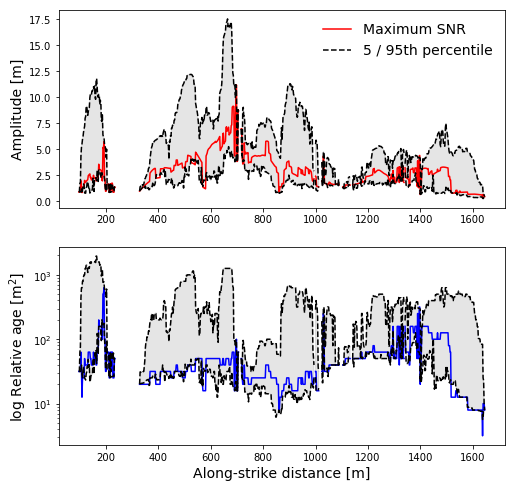

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
x = np.arange(amp.shape[0]) * dx

ax[0].fill_between(x, y1=amp5, y2=amp95, color='k', alpha=0.1)
ax[0].plot(x, best_amps, 'r-', label='Maximum SNR')
ax[0].plot(x, amp5, 'k--', label='5 / 95th percentile')
ax[0].plot(x, amp95, 'k--')
ax[0].set_ylabel('Amplitude [m]', fontsize=14)

ax[1].fill_between(x, y1=age5, y2=age95, color='k', alpha=0.1)
ax[1].plot(x, best_ages, 'b-')
ax[1].plot(x, age5, 'k--')
ax[1].plot(x, age95, 'k--')
ax[1].set(yscale='log')
ax[1].set_xlabel('Along-strike distance [m]', fontsize=14)
ax[1].set_ylabel('log Relative age [m$^2$]', fontsize=14)

leg = ax[0].legend(loc='upper right', frameon=False, fontsize=14)

We can see there's some variability and a gap around the position of Wallace Creek, at about 700 m. The gap occurs because we filtered pixels by orientation; in the channel itself, there are no pixels oriented at about 0 deg., which is the fault zone orientation in this sample dataset.

Since the fault is right-lateral in this case, the working model is that rightmost scarps were intially formed in earlier events, and the scarps closer to the creek formed more recently. As the scarps continue away from the bank of that channel, from 800 to 1400 m, they get noticeably smoother. This is captured in the gradient in the estimated ages at those locations.

Of course, this is predicated on each scarp resulting from a single surface offset. That's not usually the case, as multiple surface-rupturing earthquakes may revisit an area. This can lead to smaller subisidary slope breaks (multiple-event compositive scarps) and generally complicate the interpretation of morphologic dating.